In [1]:
import numpy as np
import pandas as pd
import ta
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from ta import add_all_ta_features
from ta import momentum
from ta.utils import dropna

In [2]:
def get_data(company_symbol):
    return pd.read_csv("dataset/"+company_symbol+".csv")

In [3]:
data = get_data("AMZN")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,5/15/1997,2.437500,2.500000,1.927083,1.958333,1.958333,72156000
1,5/16/1997,1.968750,1.979167,1.708333,1.729167,1.729167,14700000
2,5/19/1997,1.760417,1.770833,1.625000,1.708333,1.708333,6106800
3,5/20/1997,1.729167,1.750000,1.635417,1.635417,1.635417,5467200
4,5/21/1997,1.635417,1.645833,1.375000,1.427083,1.427083,18853200
...,...,...,...,...,...,...,...
6152,10/25/2021,3335.000000,3347.800049,3297.699951,3320.370117,3320.370117,2226000
6153,10/26/2021,3349.510010,3416.120117,3343.979980,3376.070068,3376.070068,2698300
6154,10/27/2021,3388.000000,3437.000000,3371.449951,3392.489990,3392.489990,2702200
6155,10/28/2021,3402.100098,3479.000000,3386.000000,3446.570068,3446.570068,5708700


In [4]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [5]:
data.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [6]:
data[data.columns[data.isna().any()]]

""
0
1
2
3
4
...
6152
6153
6154
6155


In [7]:
cond1 = data.Date.isna() # aapl['Date'].isna()
cond2 = data.Date.str.contains(r'^\s*$', na=False)
cond3 = data.Date == ''

data_checked = data.assign(cond1= cond1, cond2= cond2, cond3= cond3)
print (data_checked)

            Date         Open         High          Low        Close  \
0      5/15/1997     2.437500     2.500000     1.927083     1.958333   
1      5/16/1997     1.968750     1.979167     1.708333     1.729167   
2      5/19/1997     1.760417     1.770833     1.625000     1.708333   
3      5/20/1997     1.729167     1.750000     1.635417     1.635417   
4      5/21/1997     1.635417     1.645833     1.375000     1.427083   
...          ...          ...          ...          ...          ...   
6152  10/25/2021  3335.000000  3347.800049  3297.699951  3320.370117   
6153  10/26/2021  3349.510010  3416.120117  3343.979980  3376.070068   
6154  10/27/2021  3388.000000  3437.000000  3371.449951  3392.489990   
6155  10/28/2021  3402.100098  3479.000000  3386.000000  3446.570068   
6156  10/29/2021  3300.020020  3374.820068  3273.320068  3372.429932   

        Adj Close    Volume  cond1  cond2  cond3  
0        1.958333  72156000  False  False  False  
1        1.729167  14700000  Fals

In [8]:
def change(close):
    return (close.shift(-1) - close)

In [9]:
def direction(change):
    return (np.where(change>0, 1, 0))

In [10]:
def compute_all_indicators(data):
    data['Change'] = change(data['Close'])
    data['Direction'] = direction(data['Change'])
    return data

In [11]:
complete_data = compute_all_indicators(data)
complete_data

,Date,Open,High,Low,Close,Adj Close,Volume,Change,Direction
0,5/15/1997,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,-0.229166,0
1,5/16/1997,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,-0.020834,0
2,5/19/1997,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,-0.072916,0
3,5/20/1997,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,-0.208334,0
4,5/21/1997,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,-0.031250,0
...,...,...,...,...,...,...,...,...,...
6152,10/25/2021,3335.000000,3347.800049,3297.699951,3320.370117,3320.370117,2226000,55.699951,1
6153,10/26/2021,3349.510010,3416.120117,3343.979980,3376.070068,3376.070068,2698300,16.419922,1
6154,10/27/2021,3388.000000,3437.000000,3371.449951,3392.489990,3392.489990,2702200,54.080078,1
6155,10/28/2021,3402.100098,3479.000000,3386.000000,3446.570068,3446.570068,5708700,-74.140136,0


In [12]:
data_change_up = complete_data[complete_data['Direction'] == 1]

In [13]:
data_change_up["Change"].mean()

7.6784004198278595

In [14]:
data_change_up['Change'].sum()

24087.142117

In [26]:
data_change_up.count()

Date         3137
Open         3137
High         3137
Low          3137
Close        3137
Adj Close    3137
Volume       3137
Change       3137
Direction    3137
dtype: int64

In [15]:
data_change_down = complete_data[complete_data['Direction'] == 0]

In [16]:
data_change_down['Change'].mean()

-6.8620968923484496

In [17]:
data_change_down['Change'].sum()

-20716.670517999995

In [27]:
data_change_down.count()

Date         3020
Open         3020
High         3020
Low          3020
Close        3020
Adj Close    3020
Volume       3020
Change       3019
Direction    3020
dtype: int64

Text(0, 0.5, 'Price')

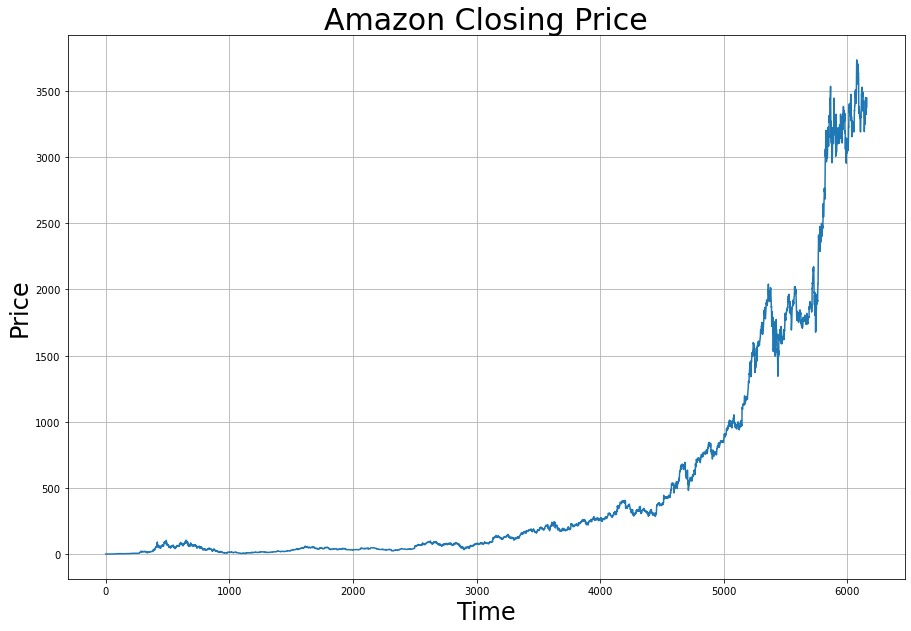

In [18]:
plt.figure(figsize=[15,10])
plt.grid(True)
plt.plot(complete_data['Close'])
#plt.plot(dataMonthly['MA'],label='3-Month MA')
#plt.legend(loc=2, fontsize=18)
plt.title("Amazon Closing Price", fontsize=30)
plt.xlabel("Time", fontsize=24)
plt.ylabel("Price", fontsize=24)

In [19]:
data_5years = complete_data.iloc[6156-1250:6156, ]

In [20]:
buy_and_hold = (data_5years.iloc[1249,4] - data_5years.iloc[0,4]) / data_5years.iloc[0,4] * 100
buy_and_hold

364.2595496628442

In [21]:
data_up_5years = data_5years[data_5years['Direction'] == 1]
data_down_5years = data_5years[data_5years['Direction'] == 0]

In [22]:
max_up = data_up_5years['Change'].sum()
max_down = data_down_5years['Change'].sum()

In [23]:
avoid_tenth = (max_up+0.9*max_down)/data_5years.iloc[0,4]*100
avoid_tenth

560.262513199018

In [24]:
theoretical_max = max_up / data_5years.iloc[0,4] * 100
theoretical_max

2414.170542214428

In [25]:
target = complete_data['Direction']
complete_data = complete_data.drop(['Date', 'Direction'], axis=1)
complete_data

,Open,High,Low,Close,Adj Close,Volume,Change
0,2.437500,2.500000,1.927083,1.958333,1.958333,72156000,-0.229166
1,1.968750,1.979167,1.708333,1.729167,1.729167,14700000,-0.020834
2,1.760417,1.770833,1.625000,1.708333,1.708333,6106800,-0.072916
3,1.729167,1.750000,1.635417,1.635417,1.635417,5467200,-0.208334
4,1.635417,1.645833,1.375000,1.427083,1.427083,18853200,-0.031250
...,...,...,...,...,...,...,...
6152,3335.000000,3347.800049,3297.699951,3320.370117,3320.370117,2226000,55.699951
6153,3349.510010,3416.120117,3343.979980,3376.070068,3376.070068,2698300,16.419922
6154,3388.000000,3437.000000,3371.449951,3392.489990,3392.489990,2702200,54.080078
6155,3402.100098,3479.000000,3386.000000,3446.570068,3446.570068,5708700,-74.140136
